<h2><font color="#004D7F" size=6>TCGA Data Analysis Tool 1.0 </font></h2>
<h3><font color="#004D7F" size=4>- Jorge Iván Díaz Riaño PhD(c)  </font></h3>

<h1><font color="#004D7F" size=4>1. Loading and preprocessing data</font></h1>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<h1><font color="#004D7F" size=4>1.1. Loading required packages and libraries </font></h1>

In [2]:
from IPython.display import display, HTML
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from lifelines import KaplanMeierFitter
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import LinearSegmentedColormap
import warnings
import io
from ipywidgets import FileUpload, Button
from IPython.display import display
from sklearn.cluster import DBSCAN
from scipy.stats import expon
from datetime import datetime

<h1><font color="#004D7F" size=4>1.2. Creating directory data structure </font></h1>

In [3]:
# Get the current working directory
working_directory = os.getcwd()
print(working_directory)
# Get the current date
current_date = datetime.now()
# Format the date as YYMMDD
formatted_date = current_date.strftime('%y%m%d')
# Define directory paths
overview_directory = os.path.join(working_directory, f"{formatted_date}_TCGA_GBM_Overview")
todea_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_GBM_ToDEA")
toPlots_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_GBM_ToPlots")
toData_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_GBM_ToData")
# Create directories if they don't exist
os.makedirs(overview_directory, exist_ok=True)
os.makedirs(todea_directory, exist_ok=True)
os.makedirs(toPlots_directory, exist_ok=True)
os.makedirs(toData_directory, exist_ok=True)
print("Directories created successfully:")
print(overview_directory)
print(todea_directory)

C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R
Directories created successfully:
C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview
C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA


<h1><font color="#004D7F" size=4>1.3. Loading input table </font></h1>

In [4]:
dataset=input("Enter path for csv file: ") #C:\\Users\\TTUSVM\\Documents\\GitHub\\TCGA-TTU\\TC3R\\Input\MAGE-TCGA-GBM_tpm_clinical.csv

Enter path for csv file: C:\\Users\\TTUSVM\\Documents\\GitHub\\TCGA-TTU\\TC3R\\Input\MAGE-TCGA-GBM_tpm_clinical.csv


In [5]:
# replace empty/invalid values with NaN
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.set_index('sample', inplace=True)
df.head(4)

,TRO,NDN,NSMCE3,MAGEC2,MAGEB2,MAGED2,MAGEB4,MAGEA9,MAGEA10,TRIM28,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,25.8521,101.6848,13.5235,0.0482,0.0598,337.5721,0.0,0.0,0.0000,193.3670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,"Pharmaceutical Therapy, NOS"
TCGA-02-0055,14.5075,89.6786,26.6422,0.2301,0.1428,349.1256,0.0,0.0,0.0264,155.1753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,"Radiation Therapy, NOS"
TCGA-02-2483,31.8243,145.3807,25.4736,1.0924,0.0000,358.0033,0.0,0.0,0.0000,425.5501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,"Pharmaceutical Therapy, NOS"
TCGA-02-2485,39.4224,88.7591,32.5229,0.1313,0.0000,364.7759,0.0,0.0,0.0000,487.4934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,"Pharmaceutical Therapy, NOS"


In [6]:
# Count of null data points
print(df.isnull().sum())

TRO                        0
NDN                        0
NSMCE3                     0
MAGEC2                     0
MAGEB2                     0
                        ... 
treatment_frequency      169
treatment_intent_type    169
treatment_or_therapy       9
treatment_outcome        169
treatment_type             1
Length: 202, dtype: int64


In [7]:
# drop columns with >0.8 NaN's
df = df.loc[:, df.isnull().mean() < .8]
#df.info()

In [8]:
df.describe()
# Write DataFrame description to CSV
df.describe().to_csv(os.path.join(toData_directory, 'DescriptiveStatistics.csv'))

<h1><font color="#004D7F" size=5>2. Visualization</font></h1>

In [9]:
df_numeric = df.select_dtypes(include=['number'])
# Reorder columns based on the provided order
column_order = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "MAGED1", "MAGED2", "TRO","MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "TRIM28", "NDN"
]
df_numeric = df_numeric[column_order]

<h1><font color="#004D7F" size=4>2.1 Distribution of TPMs expression.</font></h1>

In [11]:
# Set colors
colors_pastel = sns.color_palette("Set2")

def plot_gene_histograms_type1(gene_list):
    num_genes = len(gene_list)
    num_rows = (num_genes // 6) + (1 if num_genes % 6 != 0 else 0)  # Calculate number of rows
    plt.figure(figsize=(15, 2 * num_rows))
    for i, gene in enumerate(gene_list, start=1):
        plt.subplot(num_rows, 6, i)
        plt.hist(np.log10(df_numeric[gene] + 1), bins=20, color=colors_pastel[2], edgecolor='black')
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, 'type1_TPM_Expression_histogram.png'), dpi=300)  # Save as PNG with high quality
    plt.show()
    
def plot_gene_histograms_type2(gene_list):
    plt.figure(figsize=(15, 10))
    for gene in gene_list:
        plt.subplot(5, 6, gene_list.index(gene) + 1)
        plt.hist(np.log10(df_numeric[gene] + 1), bins=20, color=colors_pastel[5], edgecolor='black')  # Using color from palette
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, 'type2_TPM_Expression_histogram.png'), dpi=300)  # Save as PNG with high quality
    plt.show()

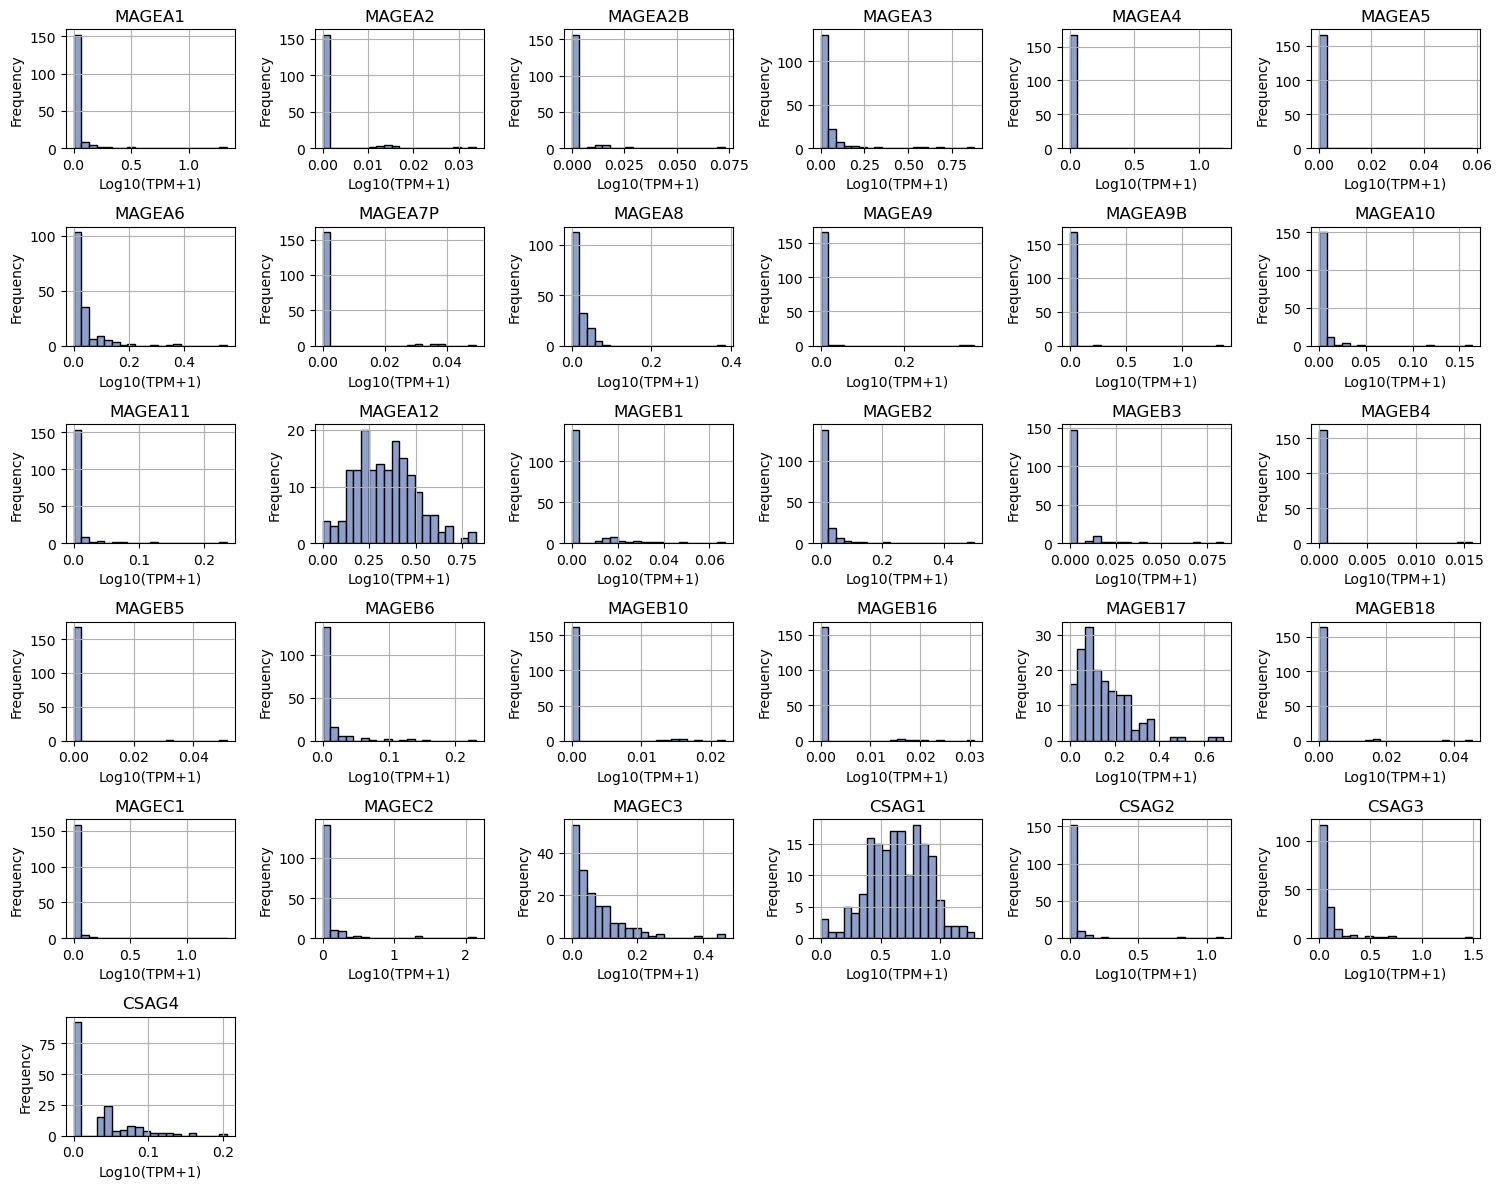

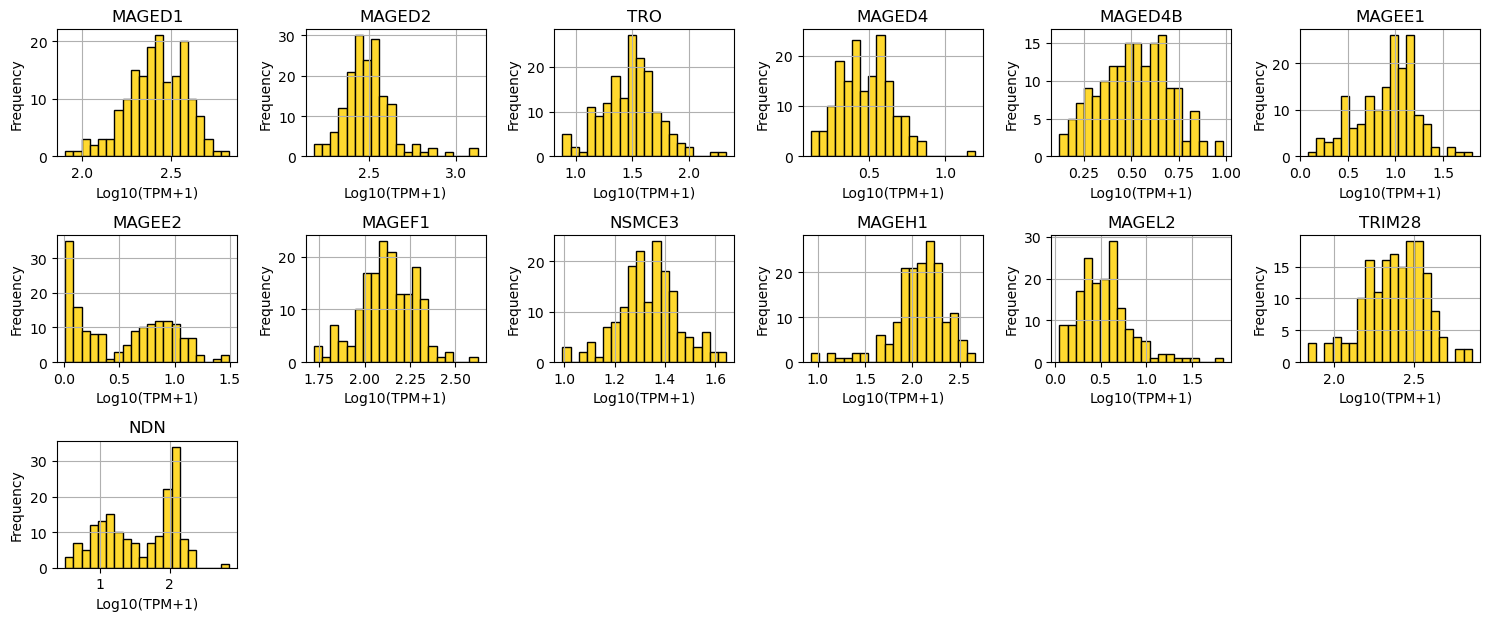

In [12]:
Type1 = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3","CSAG1", "CSAG2", "CSAG3", "CSAG4"]
Type2 = [ "MAGED1", "MAGED2", "TRO","MAGED4", "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "TRIM28", "NDN"]
plot_gene_histograms_type1(Type1)
plot_gene_histograms_type2(Type2)

<h1><font color="#004D7F" size=4>2.2. Composition of Positive and Negative Tumors by MAGEs.</font></h1>

In [14]:
no_zero = df_numeric.astype(bool).sum(axis=0)
zero = df_numeric.shape[0] - no_zero
# New df to order output
output_df = pd.DataFrame({'Positive_counts': no_zero, 'Negative_counts': zero})
output_df['Total_counts'] = output_df['Positive_counts'] + output_df['Negative_counts']
# Calculate percentages
percentage_df = output_df[['Positive_counts', 'Negative_counts']].div(output_df['Total_counts'], axis=0) * 100
# Concatenate percentages with original DataFrame
output_df = pd.concat([output_df, percentage_df.add_suffix('_percentage')], axis=1)
# Sort DataFrame by column names (alphabetical order)
output_df = output_df.sort_index()
finalTable= output_df[['Positive_counts','Positive_counts_percentage','Negative_counts','Negative_counts_percentage']]
finalTable=finalTable.round(1)
finalTable=finalTable.loc[column_order]
finalTable.to_csv(os.path.join(toData_directory, 'MAGE_PosNeg_Composition.csv'))
finalTable.head(3)

,Positive_counts,Positive_counts_percentage,Negative_counts,Negative_counts_percentage
MAGEA1,73,43.2,96,56.8
MAGEA2,14,8.3,155,91.7
MAGEA2B,13,7.7,156,92.3


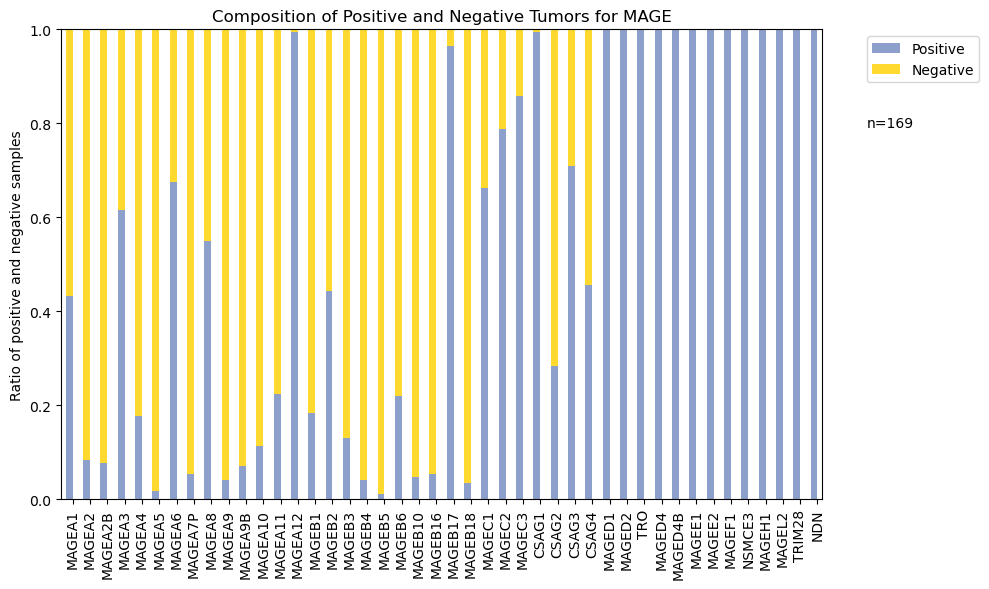

In [15]:
# Normalization
total_counts = no_zero + zero
positive_normalized = no_zero / total_counts
positive_normalized= positive_normalized[column_order]
negative_normalized = zero / total_counts
negative_normalized= negative_normalized[column_order]
# Set colors
colors_pastel = sns.color_palette("Set2")
# Stacked barplot
plt.figure(figsize=(10, 6))
positive_normalized.plot(kind='bar', color=colors_pastel[2], width=0.4, position=1, label='Positive')
negative_normalized.plot(kind='bar', color=colors_pastel[5], width=0.4, position=1, bottom=positive_normalized, label='Negative')
plt.title('Composition of Positive and Negative Tumors for MAGE')
plt.ylabel('Ratio of positive and negative samples')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.text(1.09, 0.8, 'n=169', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig(os.path.join(toPlots_directory, 'MAGE_PosNeg_Composition.png'), dpi=300)
plt.show()

<h1><font color="#004D7F" size=5>3. Analysis </font></h1>

<h1><font color="#004D7F" size=4>3.1 Correlation</font></h1>

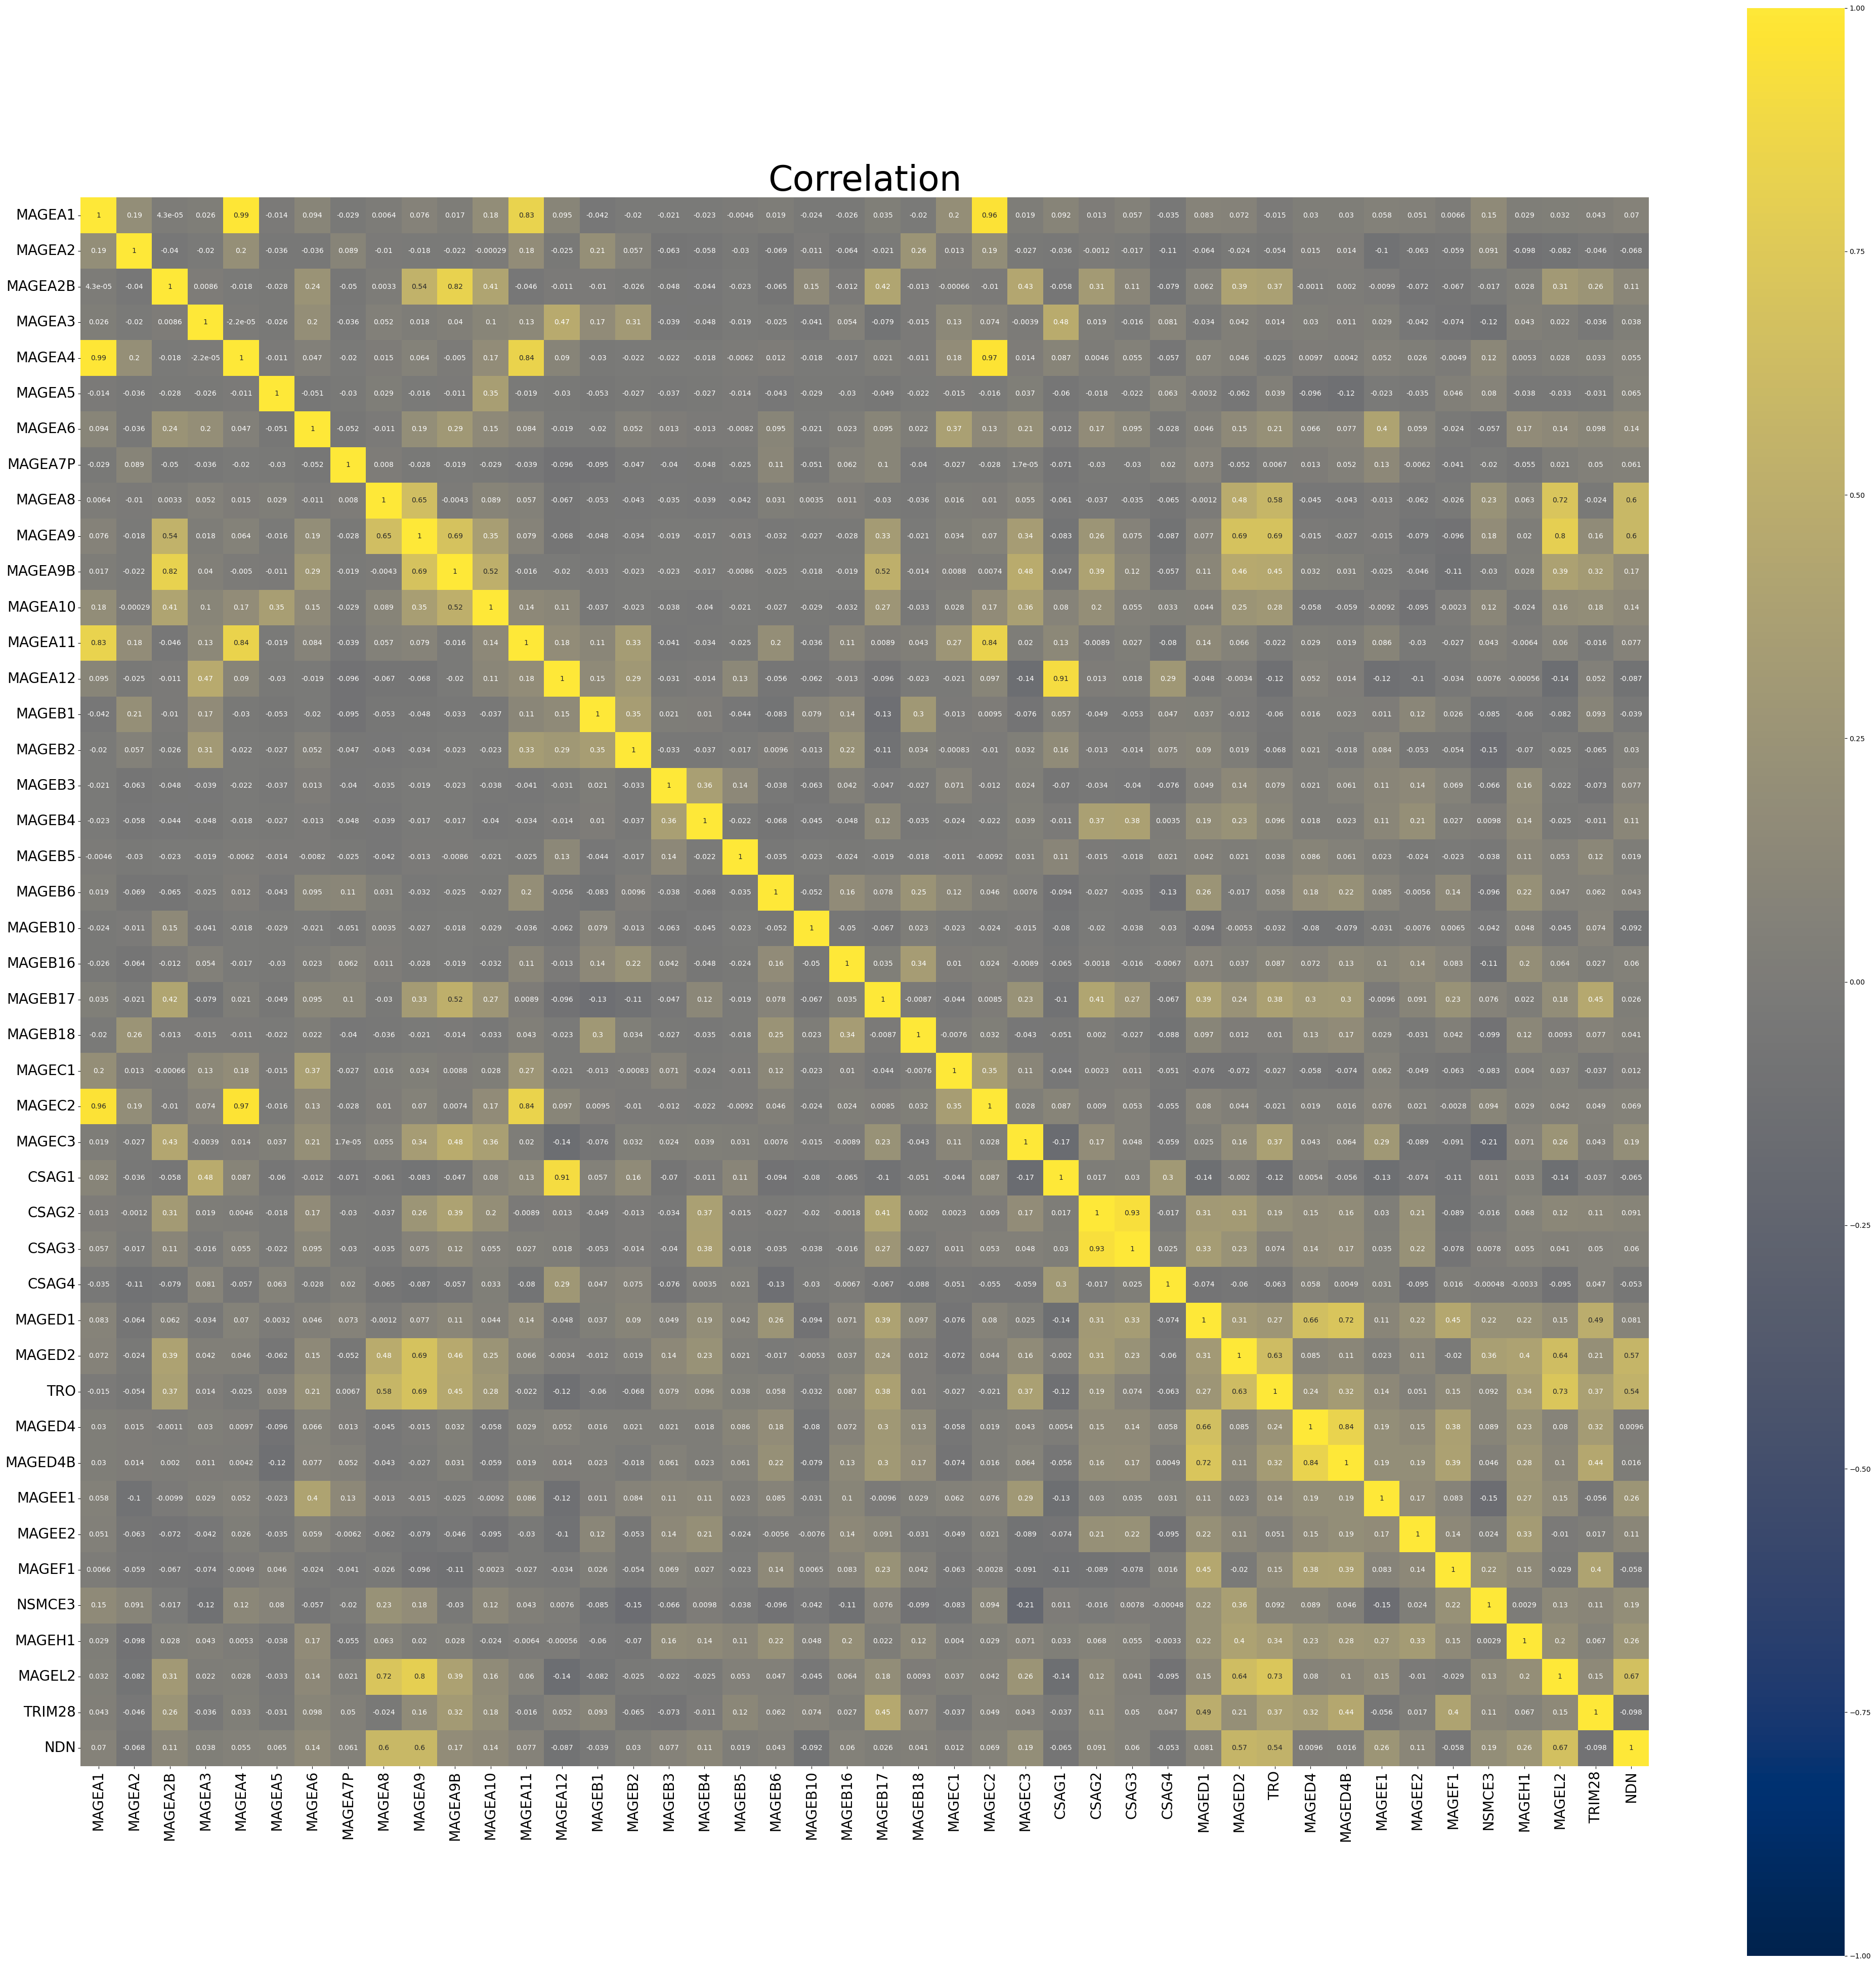

In [17]:
# Perform correlation (Pearson)
correlation = df_numeric.corr()
plt.figure(figsize=(50, 50))
ax = sns.heatmap(correlation, vmax=1, vmin=-1, square=True, annot=True, cmap='cividis')  # Correlations from -1 to 1, change to vmin
correlation.to_csv(os.path.join(toData_directory, 'MAGE_PearsonCorrelation.csv'))
plt.title('Correlation', fontsize=50)  # Increase title font size
plt.xticks(rotation=90)  # Rotate X labels to 90 degrees
plt.yticks(rotation=0)  # Rotate Y labels to default (0 degrees)
# Increase font size of tick labels
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.savefig(os.path.join(toPlots_directory, 'MAGE_PearsonCorrelation_heatmap.png'), dpi=300)
plt.show()

In [18]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''Get top absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_bottom_abs_correlations(df, n=5):
    '''Get bottom absolute correlations'''
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

def get_all_abs_correlations(df):
    '''Get all absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [19]:
numberCorr=int(input("Enter number of top/bottom correlations to be displayed: "))

Enter number of top/bottom correlations to be displayed: 10


In [25]:
# Print and save top correlations
print('Top of correlations')
topabs = get_top_abs_correlations(df_numeric, numberCorr)
print(topabs)
topabs.to_csv(os.path.join(toData_directory, f'Top_{numberCorr}_Correlation.csv'))

# Print and save bottom correlations
print('\nBottom of correlations')
botabs = get_bottom_abs_correlations(df_numeric, numberCorr)
print(botabs)
botabs.to_csv(os.path.join(toData_directory, f'Bot_{numberCorr}_Correlation.csv'))

Top of correlations
MAGEA1   MAGEA4     0.985519
MAGEA4   MAGEC2     0.968048
MAGEA1   MAGEC2     0.959018
CSAG2    CSAG3      0.934754
MAGEA12  CSAG1      0.907400
MAGEA11  MAGEC2     0.841618
MAGEA4   MAGEA11    0.838770
MAGED4   MAGED4B    0.835517
MAGEA1   MAGEA11    0.829848
MAGEA2B  MAGEA9B    0.822867
dtype: float64

Bottom of correlations
MAGEC3   NSMCE3   -0.207710
         CSAG1    -0.170379
MAGEB2   NSMCE3   -0.150764
MAGEE1   NSMCE3   -0.149634
MAGEA12  MAGEC3   -0.143343
         MAGEL2   -0.141139
CSAG1    MAGEL2   -0.138224
         MAGED1   -0.137578
         MAGEE1   -0.134939
MAGEB6   CSAG4    -0.129655
dtype: float64


<h1><font color="#004D7F" size=4>3.2 Cutoffs generation</font></h1>

In [27]:
def plot_results(sorted_df, genes, value, optimal_cutoff, sample_names):
    plt.figure(figsize=(20, 6))
    plt.bar(range(len(sorted_df[genes[0]])), np.log10(sorted_df[genes[0]] + 1), label='Expression values', color='skyblue')

    # Plot lines at the points where the curve intersects the X-axis for PosNegCriteria and cutoff_value
    posneg_criteria_value = np.log10(value+1)
    plt.axhline(y=posneg_criteria_value, color='g', linestyle='--', label='PosNegCriteria')
    plt.axhline(y=np.log10(optimal_cutoff+1), color='b', linestyle='--', label='Optimal Cutoff')

    # Find the index where the horizontal line intersects with the data for PosNegCriteria
    intersect_index_posneg = np.argmin(np.abs(np.log10(sorted_df[genes[0]]+1) - posneg_criteria_value))
    intersect_x_posneg = intersect_index_posneg
    intersect_y_posneg = np.log10(sorted_df.iloc[intersect_index_posneg][genes[0]] + 1)

    # Find the index where the horizontal line intersects with the data for Optimal Cutoff
    intersect_index_optimal = np.argmin(np.abs(np.log10(sorted_df[genes[0]]+1) - np.log10(optimal_cutoff+1)))
    intersect_x_optimal = intersect_index_optimal
    intersect_y_optimal = np.log10(sorted_df.iloc[intersect_index_optimal][genes[0]] + 1)

    # Plot vertical lines at the intersection points
    plt.axvline(x=intersect_x_posneg, color='r', linestyle='-', label='Cutoff to Positive Negative')
    plt.axvline(x=intersect_x_optimal, color='m', linestyle='-', label='Optimal Cutoff for high/medium expressed')

    plt.title(f"Expression classification according with {genes[0]}", fontsize=14)
    plt.xlabel('Samples ID')
    plt.ylabel('Log10(TPM+1)')
    plt.xticks(range(len(sample_names)), sample_names, rotation=90)  # Rotate x-axis labels by 90 degrees
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, f'Cutoff_Generation_{genes}-gene_barplot.png'), dpi=300)  # Save as PNG with high quality
    plt.show()

def find_optimal_cutoff(df, genes, value):
    # Select only the columns corresponding to the genes
    df_subset = df[genes]
    # Drop rows under positive/negative threshold
    df_subset = df_subset[(df_subset > value).any(axis=1)].dropna()
    print("Type of df_subset:", type(df_subset))
    print("Shape of df_subset:", df_subset.shape)
    # Fit an exponential distribution to the data
    params = expon.fit(df_subset.values.ravel())
    # Generate samples from the fitted distribution
    samples = expon.rvs(*params, size=1000)
    # Cluster the samples using DBSCAN
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    labels = dbscan.fit_predict(samples.reshape(-1, 1))
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("Finding optimal cutoff...")
    # Check if there are at least two clusters
    if len(unique_labels) >= 2:
        # Sort clusters by size
        sorted_clusters = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
        # Calculate the difference between the means of the two largest clusters
        cluster1_indices = np.where(labels == sorted_clusters[0][0])[0]
        cluster2_indices = np.where(labels == sorted_clusters[1][0])[0]
        cluster1_mean = np.mean(samples[cluster1_indices])
        cluster2_mean = np.mean(samples[cluster2_indices])
        diff = np.abs(cluster1_mean - cluster2_mean)
        # Update optimal cutoff and optimal difference if difference is maximized
        optimal_cutoff = np.min([cluster1_mean, cluster2_mean])
        optimal_diff = diff
        optimal_labels = labels
        min_input = np.min(df_subset)
        max_input = np.max(df_subset)
        print("Min input:", min_input)
        print("Max input:", max_input)
        print("TPM Positive/Negative threshold:", value)
        print("log10(TPM+1) Positive/Negative threshold:", np.log10(value + 1))
    else:
        print("No optimal cutoff found greater than PosNegCriteria. Returning default values.")
        return value, None, None, None
    # Sort dataframe based on the selected gene in descending order
    sorted_df = df.sort_values(by=genes[0], ascending=False)
    sample_names = sorted_df.index  # Extract sample names from index
    plot_results(sorted_df, genes, value, optimal_cutoff, sample_names)
    return optimal_cutoff, optimal_diff, optimal_labels, None

In [32]:
GeneName=input("Enter a Gene-name to be evaluated: ")
PosNegCriteria=float(input("Enter a cut-off value to separate positive and negative tumors: "))

Enter a Gene-name to be evaluated: MAGEA1
Enter a cut-off value to separate positive and negative tumors: 0


count    169.000000
mean       0.199083
std        1.594906
min        0.000000
25%        0.000000
50%        0.000000
75%        0.049000
max       20.532100
Name: MAGEA1, dtype: float64
Type of df_subset: <class 'pandas.core.frame.DataFrame'>
Shape of df_subset: (73, 1)
Finding optimal cutoff...
Min input: 0.0324
Max input: 20.5321
TPM Positive/Negative threshold: 0.0
log10(TPM+1) Positive/Negative threshold: 0.0


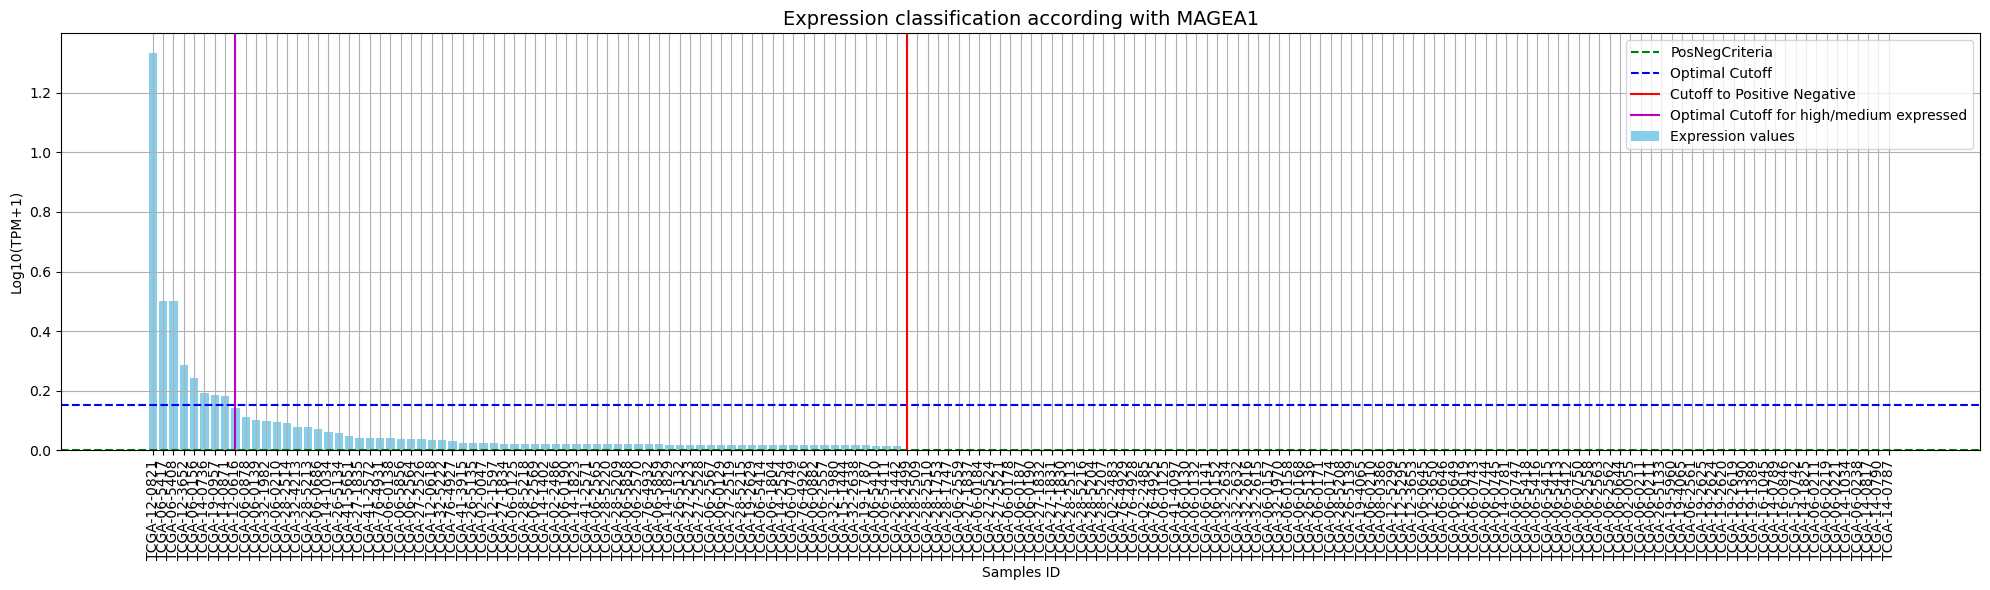

Optimal cutoff value: 0.4151412846505765 TPMs,  Normalized:  0.15079980104832233
                                            MAGEA1
Parameter                                         
TPM Positive/Negative threshold           0.000000
log10(TPM+1) Positive/Negative threshold  0.000000
Optimal cutoff value                      0.415141
Normalized                                0.150800


In [40]:
print(df[GeneName].describe())
cutoff_value, optimal_diff, optimal_labels, optimal_centroids = find_optimal_cutoff(df_numeric, [GeneName], PosNegCriteria)
if cutoff_value != -1:
    print("Optimal cutoff value:", cutoff_value, "TPMs, ", "Normalized: ", np.log10(cutoff_value + 1))
log10_PosNegCriteria = np.log10(PosNegCriteria + 1)
# Create a dictionary with the values
data = {
    "TPM Positive/Negative threshold": [PosNegCriteria],
    "log10(TPM+1) Positive/Negative threshold": [log10_PosNegCriteria],
    "Optimal cutoff value": [cutoff_value],
    "Normalized": [np.log10(cutoff_value + 1)]
}
# Convert the dictionary into a DataFrame
result_df = pd.DataFrame(data)
# Transpose the DataFrame
result_df = result_df.transpose()
# Rename the column and set the index name
result_df.columns = [GeneName]
result_df.index.name = "Parameter"
result_df.to_csv(os.path.join(toData_directory, f'OptimalCutoff_{GeneName}.csv'))
#Print the DataFrame
print(result_df)

<h1><font color="#004D7F" size=4>3.3. Heatmap</font></h1>

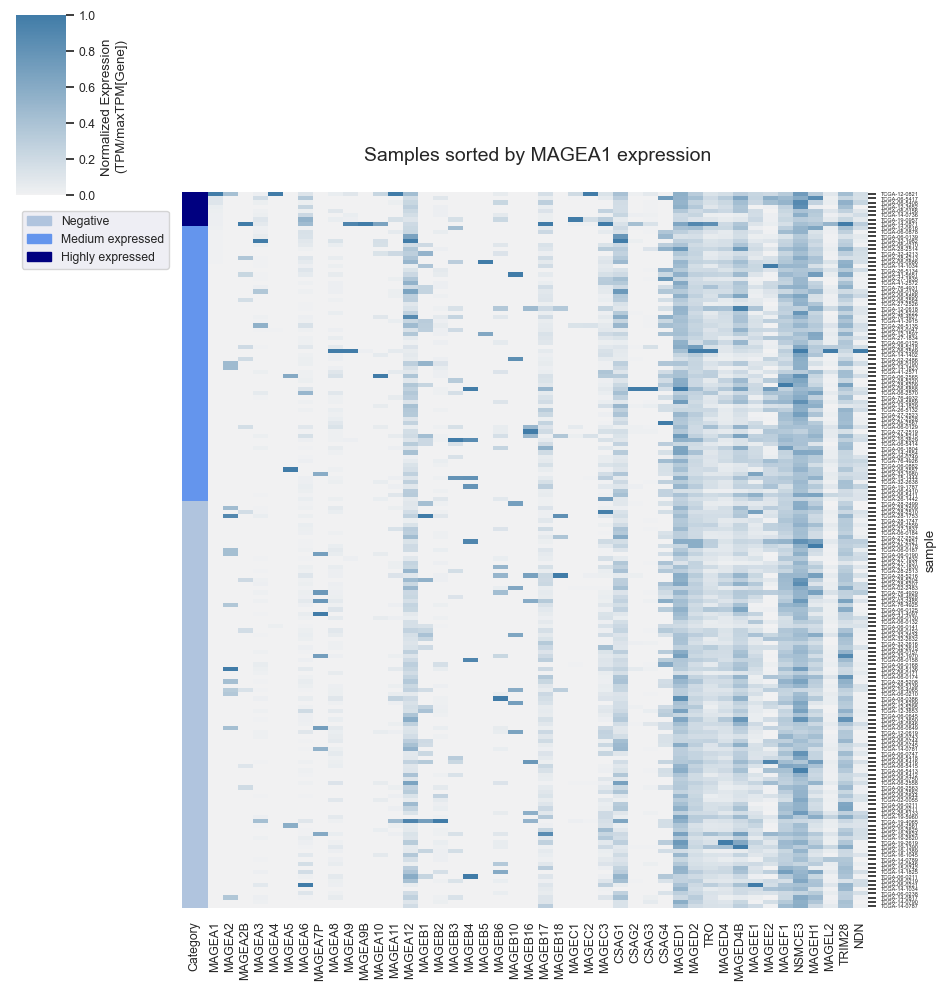

In [42]:
# Define the diverging color palette
custom_cmap = sns.diverging_palette(0, 240, as_cmap=True)
# Sort the DataFrame based on GeneName column
sorted_df_numeric = df_numeric.sort_values(by=GeneName, ascending=False)
# Group rows into categories based on sorted values of GeneName
sorted_df_numeric['Category'] = pd.cut(sorted_df_numeric[GeneName], bins=[-np.inf, PosNegCriteria, cutoff_value, np.inf], labels=['Negative', 'Medium expressed', 'Highly expressed'])
# Map categories to colors
color_map = {'Negative': 'lightsteelblue', 'Medium expressed': 'cornflowerblue', 'Highly expressed': 'navy'}
# Convert category labels to colors
row_colors = sorted_df_numeric['Category'].map(color_map)
# Define function to normalize columns except 'Category'
def normalize_column(col):
    if col.name != 'Category':
        return (col) / (col.max())
    else:
        return col
# Normalize expression values except 'Category'
normalized_df = sorted_df_numeric.apply(normalize_column, axis=0)
normalized_df.to_csv(os.path.join(toData_directory, f'SortedExpression_{GeneName}_Heatmap.csv'))
# Set font scale
sns.set(font_scale=0.8)
# Create the heatmap
g = sns.clustermap(normalized_df.drop('Category', axis=1), center=0, cbar_kws={'label': 'Normalized Expression \n(TPM/maxTPM[Gene])'}, row_cluster=False, col_cluster=False, xticklabels=True, yticklabels=True, cmap=custom_cmap, row_colors=row_colors )
# Set font size for y-axis labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=3)
# Set tick parameters
g.ax_heatmap.tick_params(axis='y', which='major', labelsize=4)
# Add text annotation indicating the ordering using GeneName
g.ax_heatmap.text(0.5, 1.05, 'Samples sorted by ' + GeneName + ' expression', horizontalalignment='center', verticalalignment='center', transform=g.ax_heatmap.transAxes, fontsize=14)
# Create a color bar for the category labels
color_bar = sns.color_palette([color_map[x] for x in ['Negative', 'Medium expressed', 'Highly expressed']])
legend = plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in color_bar], labels=color_map.keys(), bbox_to_anchor=(0.000000000001, -0.05), loc='upper left')
# Show the plot
plt.savefig(os.path.join(toPlots_directory, f'SortedExpression_{GeneName}_Heatmap.png'), dpi=300)  # Save as PNG with high quality
plt.show()

<h1><font color="#004D7F" size=4>3.4. Kaplan-Meier curve.</font></h1>

In [43]:
def find_optimal_cutoff_forKM(df, genes, value):
    # Select only the columns corresponding to the genes
    df_subset = df[genes]
    print("Name of gene:", genes)
    #print("Shape of df_subset:", df_subset.shape)
    # Drop rows under positive/negative threshold
    df_subset = df_subset[(df_subset > value).any(axis=1)].dropna()
    # Fit an exponential distribution to the data
    params = expon.fit(df_subset.values.ravel())
    # Generate samples from the fitted distribution
    samples = expon.rvs(*params, size=1000)
    # Cluster the samples using DBSCAN
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    labels = dbscan.fit_predict(samples.reshape(-1, 1))
    unique_labels, counts = np.unique(labels, return_counts=True)
    #print("Finding optimal cutoff...")
    # Check if there are at least two clusters
    if len(unique_labels) >= 2:
        # Sort clusters by size
        sorted_clusters = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
        # Calculate the difference between the means of the two largest clusters
        cluster1_indices = np.where(labels == sorted_clusters[0][0])[0]
        cluster2_indices = np.where(labels == sorted_clusters[1][0])[0]
        cluster1_mean = np.mean(samples[cluster1_indices])
        cluster2_mean = np.mean(samples[cluster2_indices])
        diff = np.abs(cluster1_mean - cluster2_mean)
        # Update optimal cutoff and optimal difference if difference is maximized
        optimal_cutoff = np.min([cluster1_mean, cluster2_mean])
        optimal_diff = diff
        optimal_labels = labels
        min_input = np.min(df_subset)
        max_input = np.max(df_subset)
    else:
        print("No optimal cutoff found greater than PosNegCriteria. Returning default values.")
        return value, None, None, None
    # Sort dataframe based on the selected gene in descending order
    sorted_df = df.sort_values(by=genes[0], ascending=False)
    sample_names = sorted_df.index  # Extract sample names from index
    return optimal_cutoff, optimal_diff, optimal_labels, None

Name of gene: ['MAGEA1']
Name of gene: ['MAGEA2']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA2B']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA3']
Name of gene: ['MAGEA4']
Name of gene: ['MAGEA5']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA6']
Name of gene: ['MAGEA7P']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA8']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA9']
Name of gene: ['MAGEA9B']
Name of gene: ['MAGEA10']
Name of gene: ['MAGEA11']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA12']
Name of gene: ['MAGEB1']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEB2']
No optimal cutoff found greater than PosN

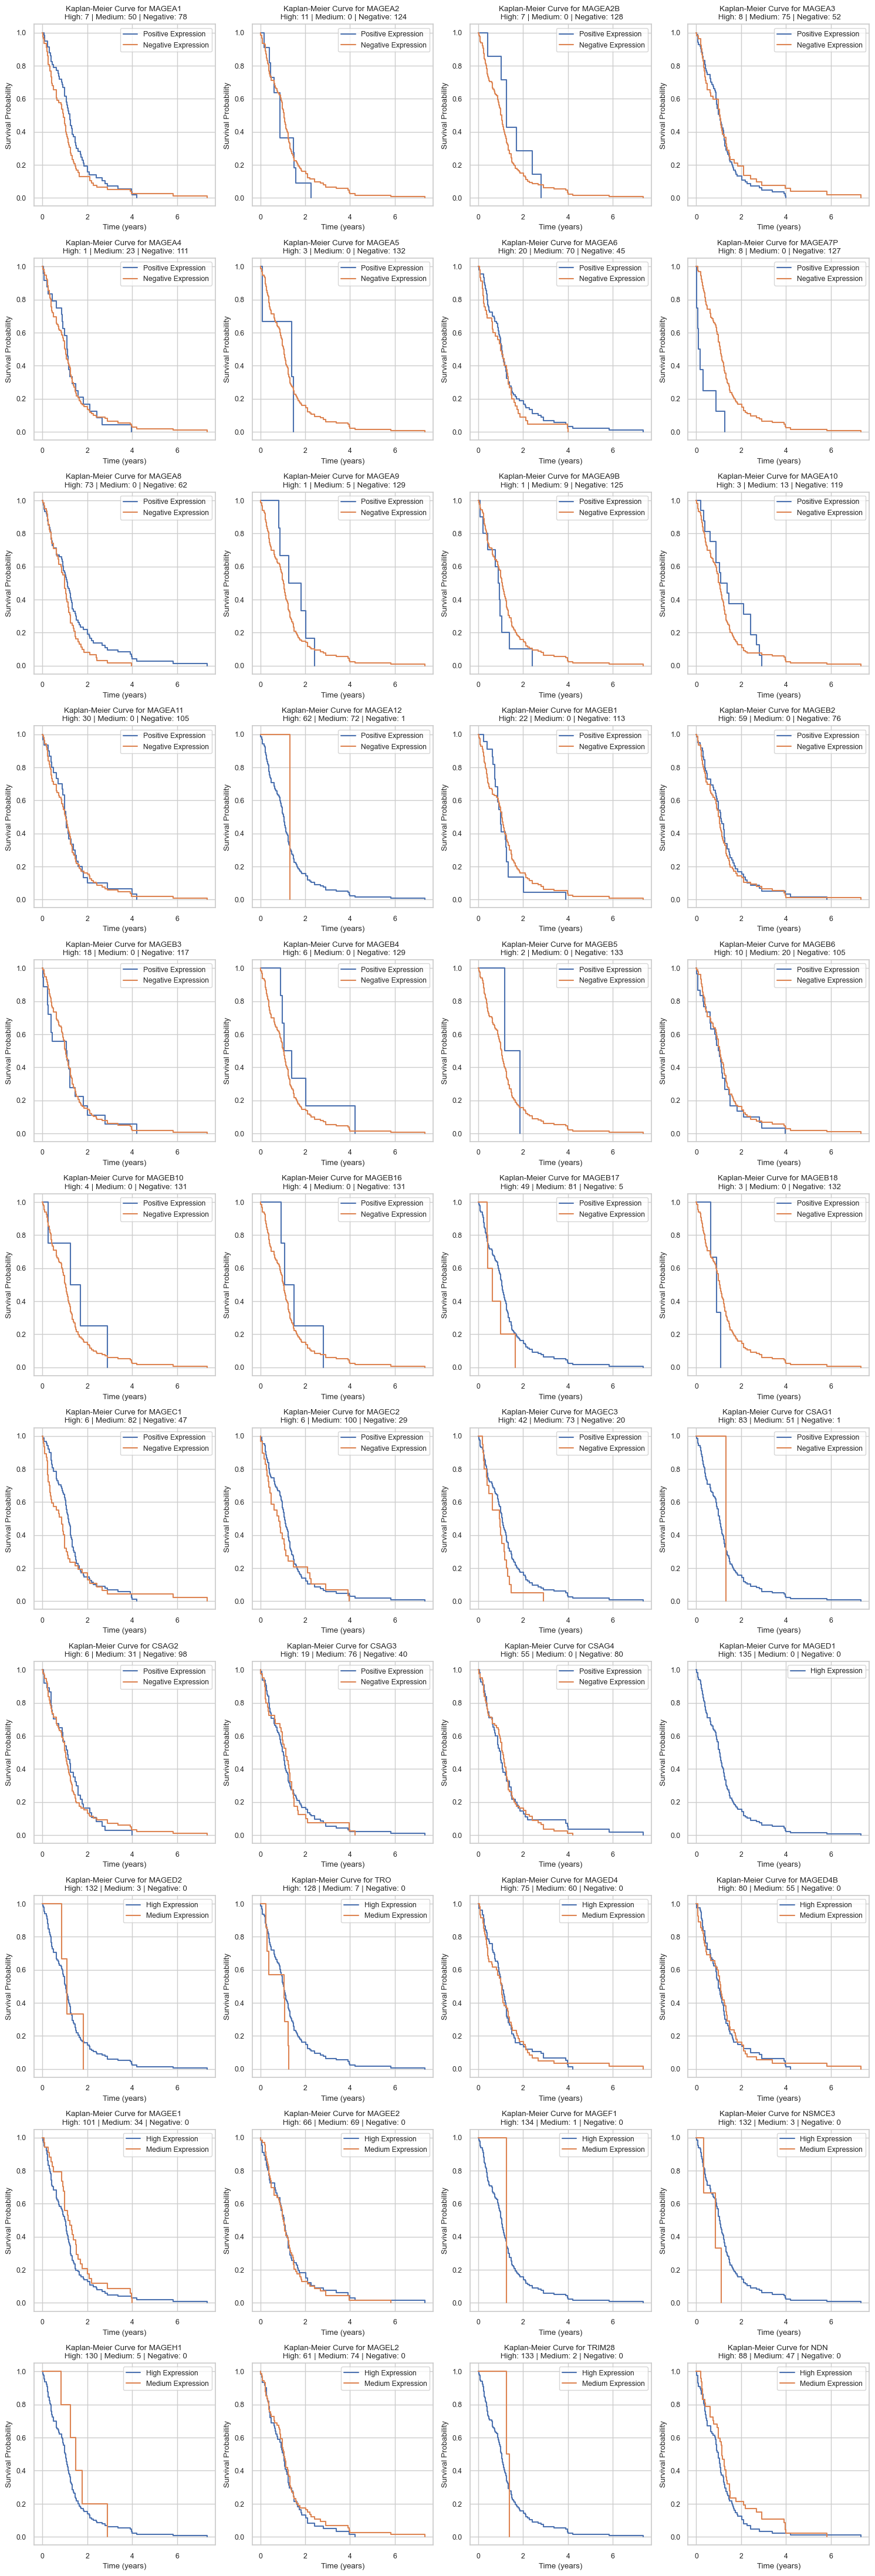

In [44]:
# Drop rows with missing or non-numeric values
df = df.dropna(subset=['days_to_death', 'vital_status'])
df = df[pd.to_numeric(df['days_to_death'], errors='coerce').notnull()]  # Ensure 'days_to_death' contains numeric values
df['days_to_death'] = pd.to_numeric(df['days_to_death'], errors='coerce')
# Convert 'vital_status' to categorical values
df['vital_status'] = df['vital_status'].astype('category')
# Plotting
num_cols = 4
num_rows = (len(column_order) + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(15, 4 * num_rows))  # Adjust figure size based on the number of rows
sns.set_style("whitegrid")

# Iterate over each gene column
for i, gene in enumerate(column_order):
    plt.subplot(num_rows, num_cols, i + 1)
    cutoff_value, optimal_diff, optimal_labels, optimal_centroids = find_optimal_cutoff_forKM(df, [gene], 0)
    # Filter the data based on gene expression levels
    high_expr_data = df[df[gene] > cutoff_value]
    medium_expr_data = df[(df[gene] > 0) & (df[gene] <= cutoff_value)]
    negative_expr_data = df[df[gene] == 0]  # Filter for values equal to 0
    #print(f' {high_expr_data.shape[0]},{medium_expr_data.shape[0]},{negative_expr_data.shape[0]}, {high_expr_data.shape[0]+medium_expr_data.shape[0]+negative_expr_data.shape[0]}' )
    # Check if there are no negative expression data points
    if negative_expr_data.shape[0] == 0:
        # Fit the Kaplan-Meier curve for high expression data
        kmf = KaplanMeierFitter()
        kmf.fit(durations=high_expr_data['days_to_death']/365, event_observed=high_expr_data['vital_status'] == 'Dead', label='High Expression')
        kmf.plot(ci_show=False)
        # Fit the Kaplan-Meier curve for medium expression data if there are entries
        if not medium_expr_data.empty:
            kmf.fit(durations=medium_expr_data['days_to_death']/365, event_observed=medium_expr_data['vital_status'] == 'Dead', label='Medium Expression')
            kmf.plot(ci_show=False)
    else:
        positive_expr_data = pd.concat([high_expr_data, medium_expr_data])
        # Create a KaplanMeierFitter object
        kmf = KaplanMeierFitter()
        # Fit the Kaplan-Meier curve for positive expression data
        kmf.fit(durations=positive_expr_data['days_to_death']/365, event_observed=positive_expr_data['vital_status'] == 'Dead', label='Positive Expression')
        kmf.plot(ci_show=False)
        if not negative_expr_data.empty:
            kmf.fit(durations=negative_expr_data['days_to_death']/365, event_observed=negative_expr_data['vital_status'] == 'Dead', label='Negative Expression')
            kmf.plot(ci_show=False)

    # Add labels and title
    plt.xlabel('Time (years)')
    plt.ylabel('Survival Probability')
    plt.title(f'Kaplan-Meier Curve for {gene} \n High: {high_expr_data.shape[0]} | Medium: {medium_expr_data.shape[0]} | Negative: {negative_expr_data.shape[0]}')
    # Add legend
    plt.legend()
plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.savefig(os.path.join(toPlots_directory, f'Kaplan-Meier.png'), dpi=300)  # Save as PNG with high quality
plt.show()

In [45]:
################ CREATING FILES TO DEA  ##############################################
# Iterate over each gene column
for i, gene in enumerate(column_order):
    cutoff_value, optimal_diff, optimal_labels, optimal_centroids = find_optimal_cutoff_forKM(df, [gene], 0)
    # Filter the data based on gene expression levels
    high_expr_data = df[df[gene] > cutoff_value]
    medium_expr_data = df[(df[gene] > 0) & (df[gene] <= cutoff_value)]
    negative_expr_data = df[df[gene] == 0]
    minimumSamples=3 # minimum of samples per category to perform DEA
    if cutoff_value ==0:
        if int(negative_expr_data.shape[0]) >= minimumSamples:
            positive_expr_data = pd.concat([high_expr_data, medium_expr_data])
            print(f'Creating Negative ({negative_expr_data.shape[0]}) vs Positive ({positive_expr_data.shape[0]}) cls file')
            # obtaining samples names
            positiveSamples=positive_expr_data.index
            negativeSamples=negative_expr_data.index
            #Creating dataframes
            negativesdf=pd.DataFrame(negativeSamples)
            negativesdf['condition']= 'Control'
            positivesdf= pd.DataFrame(positiveSamples)
            positivesdf['condition']= 'Treatment'
            #merging and writing to csv
            combined_df = pd.concat([negativesdf, positivesdf], ignore_index=True)
            filename=os.path.join(todea_directory, f"{formatted_date}_TCGA_GBM_{gene}_NEGvsPOS.csv")
            combined_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename} \n')
        else:
            print(f'Please modify positive/negative cutoff to have at least 3 samples per category. Current: {negative_expr_data.shape[0]} negative samples and {positive_expr_data.shape[0]} positive samples\n')
    else:  
        if medium_expr_data.shape[0] >=minimumSamples and high_expr_data.shape[0] >=minimumSamples and negative_expr_data.shape[0] >=minimumSamples: #all categories accomplished
            print(f'Creating Medium ({medium_expr_data.shape[0]})  vs High ({high_expr_data.shape[0]}), Negative ({negative_expr_data.shape[0]}) vs High ({high_expr_data.shape[0]}), and Negative ({negative_expr_data.shape[0]}) vs Medium ({medium_expr_data.shape[0]})cls files')
             # obtaining samples names
            highSamples=high_expr_data.index
            mediumSamples = medium_expr_data.index
            negativeSamples=negative_expr_data.index
            
            #merging and writing to csv
            mediumdf=pd.DataFrame(mediumSamples)
            mediumdf['condition']= 'Control'
            highdf= pd.DataFrame(highSamples)
            highdf['condition']= 'Treatment'
            combined_df = pd.concat([mediumdf, highdf], ignore_index=True)
            filename=os.path.join(todea_directory, f"{formatted_date}_TCGA_GBM_{gene}_MEDvsHIG.csv")
            combined_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}')
            
            negativesdf=pd.DataFrame(negativeSamples)
            negativesdf['condition']= 'Control'
            highdf= pd.DataFrame(highSamples)
            highdf['condition']= 'Treatment'
            combined2_df = pd.concat([negativesdf, highdf], ignore_index=True)
            filename=os.path.join(todea_directory, f"{formatted_date}_TCGA_GBM_{gene}_NEGvsHIG.csv")
            combined2_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}')
            
            negativesdf=pd.DataFrame(negativeSamples)
            negativesdf['condition']= 'Control'
            mediumdf=pd.DataFrame(mediumSamples)
            mediumdf['condition']= 'Treatment'
            combined3_df = pd.concat([negativesdf, mediumdf], ignore_index=True)
            filename=os.path.join(todea_directory, f"{formatted_date}_TCGA_GBM_{gene}_NEGvsMED.csv")
            combined3_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}\n')
            
        elif medium_expr_data.shape[0] <minimumSamples or high_expr_data.shape[0] <minimumSamples and negative_expr_data.shape[0] >=minimumSamples: #medium or high are insufficient
            positive_expr_data = pd.concat([high_expr_data, medium_expr_data])
            print(f'Creating Negative ({negative_expr_data.shape[0]}) vs Positive ({positive_expr_data.shape[0]}) cls file due to small (<3) sample size for High ({high_expr_data.shape[0]}) or Medium ({medium_expr_data.shape[0]}) categories')        
            # obtaining samples names
            positiveSamples=positive_expr_data.index
            negativeSamples=negative_expr_data.index
            #Creating dataframes
            negativesdf=pd.DataFrame(negativeSamples)
            negativesdf['condition']= 'Control'
            positivesdf= pd.DataFrame(positiveSamples)
            positivesdf['condition']= 'Treatment'
            #merging and writing to csv
            combined_df = pd.concat([negativesdf, positivesdf], ignore_index=True)
            filename=os.path.join(todea_directory, f"{formatted_date}_TCGA_GBM_{gene}_NEGvsPOS.csv")
            combined_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}\n')
        elif negative_expr_data.shape[0] <minimumSamples and (medium_expr_data.shape[0] <minimumSamples or high_expr_data.shape[0] <minimumSamples): #Only medium or only High
            print(f'Please modify positive/negative cutoff to have at least 3 samples per category. Current: {negative_expr_data.shape[0]} negative, {medium_expr_data.shape[0]} medium ,and {high_expr_data.shape[0]} high samples\n')
        else: #Case for typical Type 2 gene (Negative <3 and samples are into High and medium)
            print(f'Creating High ({high_expr_data.shape[0]}) vs Medium ({medium_expr_data.shape[0]}) cls file due to small (<3) sample size for Negative category ({negative_expr_data.shape[0]})')
            # obtaining samples names
            highSamples=high_expr_data.index
            mediumSamples = medium_expr_data.index
            #Creating dataframes
            mediumdf=pd.DataFrame(mediumSamples)
            mediumdf['condition']= 'Control'
            highdf= pd.DataFrame(highSamples)
            highdf['condition']= 'Treatment'
            #merging and writing to csv
            combined_df = pd.concat([mediumdf, highdf], ignore_index=True)
            filename=os.path.join(todea_directory, f"{formatted_date}_TCGA_GBM_{gene}_MEDvsHIG.csv")
            combined_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}\n')

Name of gene: ['MAGEA1']
Creating Medium (50)  vs High (7), Negative (78) vs High (7), and Negative (78) vs Medium (50)cls files
Combined data has been written to: C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA\240325_TCGA_GBM_MAGEA1_MEDvsHIG.csv
Combined data has been written to: C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA\240325_TCGA_GBM_MAGEA1_NEGvsHIG.csv
Combined data has been written to: C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA\240325_TCGA_GBM_MAGEA1_NEGvsMED.csv

Name of gene: ['MAGEA2']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Creating Negative (124) vs Positive (11) cls file
Combined data has been written to: C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA\240325_TCGA_GBM_MAGEA2_NEGvsPOS.csv 

Name of gene: ['MAGEA2B']
No optimal cutoff found grea

Creating Medium (81)  vs High (49), Negative (5) vs High (49), and Negative (5) vs Medium (81)cls files
Combined data has been written to: C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA\240325_TCGA_GBM_MAGEB17_MEDvsHIG.csv
Combined data has been written to: C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA\240325_TCGA_GBM_MAGEB17_NEGvsHIG.csv
Combined data has been written to: C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA\240325_TCGA_GBM_MAGEB17_NEGvsMED.csv

Name of gene: ['MAGEB18']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Creating Negative (132) vs Positive (3) cls file
Combined data has been written to: C:\Users\TTUSVM\Documents\GitHub\TCGA-TTU\TC3R\240325_TCGA_GBM_Overview\240325_TCGA_GBM_ToDEA\240325_TCGA_GBM_MAGEB18_NEGvsPOS.csv 

Name of gene: ['MAGEC1']
Creating Medium (82)  vs High (6), Negative (47) v